In [1]:
%pip install ..

Processing /home/bpc/Documents/memorytools
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for memorytools: filename=memorytools-0.1.0-py3-none-any.whl size=10481 sha256=577254da187993bcf97118b2f769c36f77ec3db061ea2ac0321130f27d4a5a28
  Stored in directory: /tmp/pip-ephem-wheel-cache-e935f4fu/wheels/83/d1/b0/5f5772eb16dc6152c130b096fab71055d247aea68ef4046965
Successfully built memorytools
  Attempting uninstall: memorytools
    Found existing installation: memorytools 0.1.0
    Uninstalling memorytools-0.1.0:
      Successfully uninstalled memorytools-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import test_memory_monitor
from memorytools.memorymonitor import MemoryMonitor

# Test Server

The test server stored in [test/test_server.py](memorytools/test/test_server.py) provides an example program for development and testing of the memory monitor, it has the ability to act like a memory leaking process and a normal process that properly tidies up after itself. 

The test server provides a practical and controlled environment to test the effectiveness of the memory monitor. We can use this to ensure it can accurately track memory usage and identify memory leaks. 

After creating a function which simulates memory leaks in reference to the general forms which these take as suggested in [Memory Leak Detection in Cloud based infastructure](), testing these via visulisation and comparison, adjusting the time frames for the simulator such that they match the timeframes we might expect for a unit test (at a minimum). We shall then work to apply the LBR method onto the simulator, tuning a number of the parameters to detect the leaks.

Once we were able to detect simulated memory leaks we try applying the methods to known leaking and not leaking revisions of TDCS to see how this works.


## Startup test server

In [3]:
import subprocess
import time

global PORT
PORT = 8130

#Spawn a test_server.py with Popen, yield and then kill it
proc = subprocess.Popen(["python3", "test_server.py"])
if(proc.poll() is not None):
    proc.kill()
    raise Exception("Test server failed to start")
time.sleep(5)

Serving at port 8130


In [4]:
proc.pid

199377

## Functions for interacting with the test server

In [5]:
import requests


def send_memory_request(server=None):
    response = requests.get(f"http://127.0.0.1:8130/addmem")
    assert response.status_code==200

def send_memory_clear_request(server=None):
    send_memory_request(server)
    response = requests.get(f"http://127.0.0.1:8130/clrmem")
    assert response.status_code==200


import time


# Simple memory leak 

We start by simulating a memory leak that shows a very simple memory leak that simply increased memory usage over time. This is at a consistent rate with no major gaps either in the data or between increase in memory usage. A memory leak occurs when a program allocates memory but fails to release it, leading to a gradual increase in memory usage over time. 

The function provides a way to simulate a memory leak by continuously sending a memory request to the test server for a passed in duration with sleeps between these requests of a size duration/50 which simulates a the delay between real life memory allocations. 50 iterations are used to ensure we get a large number of memory increases.

This case, where memory usage consistently increases without any major gaps in the data or between the increases, would be characteristic of a leak from a specific section of code that is allocating and then not releasng memory.

## Simple memory leak function 

In [6]:
def simulate_memory_leak(server, duration=60):
    """
    Simulate a memory leak by continuously sending memory requests to a server.

    Parameters:
    server: The server to send the memory requests to.
    duration: The duration in seconds for which to simulate the memory leak, in seconds. Defaults to 60.
    """
    send_memory_clear_request(server)
    start_time = time.time()
    while time.time() - start_time < duration:
        send_memory_request(server)
        time.sleep(duration/20)  # Pause for a second between requests

## Internal parameters 

In [7]:
#Parameters
from memorytools import memoryanalysis
from datetime import timedelta
import psutil as ps

memoryanalysis.WIN_MIN_NUM_POINTS_RESAMPLE = 10 #Number of points in a dataset required to do a resample/any further analysis. Filters out very short running processes
memoryanalysis.RESAMPLE_MIN_WIN = timedelta(seconds=0.5).total_seconds() # 5ms as the resampled minimum domain gaps, should be an increase on the recorded delta time
memoryanalysis.WIN_MIN_NUM_POINTS_DETECT =  int(600) # points = 1s would be the smallest window size even allowed such that only behaviour that lasts for this amount of time is considered
memoryanalysis.R_SQR_MIN = 0.9 #Require an increased confidence from the papers default of 0.8 since we are using a significantly smaller window size
memoryanalysis.CRITICAL_TIME_MAX = 60*60*1 # 1 hours
memoryanalysis.CRITICAL_MEMORY_USAGE = ps.virtual_memory().total
memoryanalysis.MAX_TIME_DIFF = 0.5
memoryanalysis.DEBUG_PLOTTING = True

In [8]:
#Parameters
from memorytools import memoryanalysis
from datetime import timedelta
import psutil as ps

memoryanalysis.WIN_MIN_NUM_POINTS_RESAMPLE = 10 #Number of points in a dataset required to do a resample/any further analysis. Filters out very short running processes
memoryanalysis.RESAMPLE_MIN_WIN = timedelta(seconds=0.5).total_seconds() # 5ms as the resampled minimum domain gaps, should be an increase on the recorded delta time
memoryanalysis.WIN_MIN_NUM_POINTS_DETECT =  int(20) # points = 10s would be the smallest window size even with 
memoryanalysis.R_SQR_MIN = 0.9 #Require an increased confidence from the papers default of 0.8 since we are using a significantly smaller window size
memoryanalysis.CRITICAL_TIME_MAX = 60*60*1 # 1 hours
memoryanalysis.CRITICAL_MEMORY_USAGE = ps.virtual_memory().total
memoryanalysis.MAX_TIME_DIFF = 0.5
memoryanalysis.DEBUG_PLOTTING = True

## Recording and simulating of data

In [9]:
mem_mon = MemoryMonitor(time_interval=0.05)
mem_mon.start_monitoring()
time.sleep(10)
simulate_memory_leak(proc, 10)
time.sleep(10)
mem_mon.stop_monitoring()

NO MEMORY DATA FILE FOUND


0
Added memory
397316096
remove memory
0
Added memory
399310848


127.0.0.1 - - [16/May/2024 17:07:10] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:10] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:10] "GET /addmem HTTP/1.1" 200 -


1
Added memory
408313856


127.0.0.1 - - [16/May/2024 17:07:11] "GET /addmem HTTP/1.1" 200 -


2
Added memory
417312768


127.0.0.1 - - [16/May/2024 17:07:11] "GET /addmem HTTP/1.1" 200 -


3
Added memory
425312256


127.0.0.1 - - [16/May/2024 17:07:12] "GET /addmem HTTP/1.1" 200 -


4
Added memory
433311744


127.0.0.1 - - [16/May/2024 17:07:12] "GET /addmem HTTP/1.1" 200 -


5
Added memory
441311232


127.0.0.1 - - [16/May/2024 17:07:13] "GET /addmem HTTP/1.1" 200 -


6
Added memory
449314816


127.0.0.1 - - [16/May/2024 17:07:13] "GET /addmem HTTP/1.1" 200 -


7
Added memory
457314304


127.0.0.1 - - [16/May/2024 17:07:14] "GET /addmem HTTP/1.1" 200 -


8
Added memory
465313792


127.0.0.1 - - [16/May/2024 17:07:14] "GET /addmem HTTP/1.1" 200 -


9
Added memory
473313280


127.0.0.1 - - [16/May/2024 17:07:15] "GET /addmem HTTP/1.1" 200 -


10
Added memory
481312768


127.0.0.1 - - [16/May/2024 17:07:15] "GET /addmem HTTP/1.1" 200 -


11
Added memory
489312256


127.0.0.1 - - [16/May/2024 17:07:16] "GET /addmem HTTP/1.1" 200 -


12
Added memory
497311744


127.0.0.1 - - [16/May/2024 17:07:16] "GET /addmem HTTP/1.1" 200 -


13
Added memory
505311232


127.0.0.1 - - [16/May/2024 17:07:17] "GET /addmem HTTP/1.1" 200 -


14
Added memory
513314816


127.0.0.1 - - [16/May/2024 17:07:17] "GET /addmem HTTP/1.1" 200 -


15
Added memory
521314304


127.0.0.1 - - [16/May/2024 17:07:18] "GET /addmem HTTP/1.1" 200 -


16
Added memory
529313792


127.0.0.1 - - [16/May/2024 17:07:18] "GET /addmem HTTP/1.1" 200 -


17
Added memory
537313280


127.0.0.1 - - [16/May/2024 17:07:19] "GET /addmem HTTP/1.1" 200 -


18
Added memory
545312768


127.0.0.1 - - [16/May/2024 17:07:19] "GET /addmem HTTP/1.1" 200 -


19
Added memory
553312256


127.0.0.1 - - [16/May/2024 17:07:20] "GET /addmem HTTP/1.1" 200 -


## Visulise test server to see if it matches expected

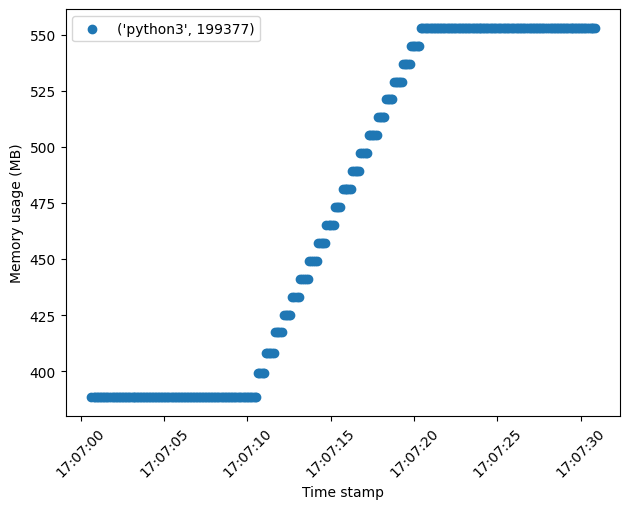

<module 'matplotlib.pyplot' from '/home/bpc/Documents/memorytools/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [10]:
mem_mon.plot_data_to_screen(proc_pids=[proc.pid])

As we see above the test server is showing a very large growth in memory usage over time over a time period of 10 seconds, as we might expect from a extreme memory leak 

## Running leak detection algorithm on the simple memory leak simulation

0.9000448805032598


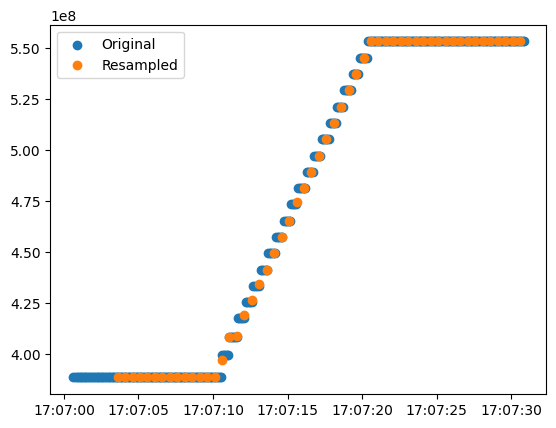

Abnormal memory usage detected in process: python3with pid 199377


(['python3'], [199377])
Time taken to detect memory leak: 1.9478991031646729 seconds


In [11]:
import time
start_time = time.time()
print(mem_mon.detect_leaks("LBR"))
end_time = time.time() - start_time

print(f"Time taken to detect memory leak: {end_time} seconds")

# Sawtooth leak testing

A sawtooth memory leak refers to a specific type of memory leak that occurs when the memory usage of a program gradually increases over time, but periodically drops back down to a lower level before increasing again. This pattern resembles the teeth of a saw, hence the name "sawtooth."

Memory leaks occur when a program allocates memory but fails to release it when it is no longer needed. Over time, these unreleased memory blocks accumulate, leading to increased memory usage. In a sawtooth memory leak, the memory usage periodically drops coinciding with reboots or restarts of that application or module. It can be difficult to compare these shapes since garbage collection points/normal behaviour can also cause such a pattern and would show a healthy usage of the heap.

Sawtooth memory leaks can be particularly challenging to identify and fix because the periodic drops in memory usage can create the illusion that the leak is not present. However, the repeated trend of increasing memory usage over time indicates the presence of a leak that is not becoming problematic due to some form of resetting. In a lot of ESO software this resetting could be down to things like a process going to the standardised OFF state.

## Sawtooth leak function development

The sawtooth simulation function will make use of the simple memory leak function, where a simple memory leak is simulated and then afterwards cleared, this is repeated a number of times. This is a structure that could add confusion to a detector given the clearing and growing nature.

In [12]:
def simulate_sawtooth_memory_leak(server):
    for _ in range(3): #60 seconds 
        simulate_memory_leak(server,10)
        send_memory_clear_request(server)

## Recording and simulating of data

In [13]:
mem_mon_sawtooth = MemoryMonitor(time_interval=0.05)
mem_mon_sawtooth.start_monitoring()
time.sleep(10)
simulate_sawtooth_memory_leak(proc)
time.sleep(10)
mem_mon_sawtooth.stop_monitoring()

NO MEMORY DATA FILE FOUND
127.0.0.1 - - [16/May/2024 17:07:33] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:33] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:33] "GET /addmem HTTP/1.1" 200 -


20
Added memory
561311744
remove memory
0
Added memory
407314432
1
Added memory
415313920


127.0.0.1 - - [16/May/2024 17:07:33] "GET /addmem HTTP/1.1" 200 -


2
Added memory
423313408


127.0.0.1 - - [16/May/2024 17:07:34] "GET /addmem HTTP/1.1" 200 -


3
Added memory
431312896


127.0.0.1 - - [16/May/2024 17:07:34] "GET /addmem HTTP/1.1" 200 -


4
Added memory
439312384


127.0.0.1 - - [16/May/2024 17:07:35] "GET /addmem HTTP/1.1" 200 -


5
Added memory
447311872


127.0.0.1 - - [16/May/2024 17:07:35] "GET /addmem HTTP/1.1" 200 -


6
Added memory
455315456


127.0.0.1 - - [16/May/2024 17:07:36] "GET /addmem HTTP/1.1" 200 -


7
Added memory
463314944


127.0.0.1 - - [16/May/2024 17:07:36] "GET /addmem HTTP/1.1" 200 -


8
Added memory
471314432


127.0.0.1 - - [16/May/2024 17:07:37] "GET /addmem HTTP/1.1" 200 -


9
Added memory
479313920


127.0.0.1 - - [16/May/2024 17:07:37] "GET /addmem HTTP/1.1" 200 -


10
Added memory
487313408


127.0.0.1 - - [16/May/2024 17:07:38] "GET /addmem HTTP/1.1" 200 -


11
Added memory
495312896


127.0.0.1 - - [16/May/2024 17:07:38] "GET /addmem HTTP/1.1" 200 -


12
Added memory
503312384


127.0.0.1 - - [16/May/2024 17:07:39] "GET /addmem HTTP/1.1" 200 -


13
Added memory
511311872


127.0.0.1 - - [16/May/2024 17:07:39] "GET /addmem HTTP/1.1" 200 -


14
Added memory
519315456


127.0.0.1 - - [16/May/2024 17:07:40] "GET /addmem HTTP/1.1" 200 -


15
Added memory
527314944


127.0.0.1 - - [16/May/2024 17:07:40] "GET /addmem HTTP/1.1" 200 -


16
Added memory
535314432


127.0.0.1 - - [16/May/2024 17:07:41] "GET /addmem HTTP/1.1" 200 -


17
Added memory
543313920


127.0.0.1 - - [16/May/2024 17:07:41] "GET /addmem HTTP/1.1" 200 -


18
Added memory
551313408


127.0.0.1 - - [16/May/2024 17:07:42] "GET /addmem HTTP/1.1" 200 -


19
Added memory
559312896


127.0.0.1 - - [16/May/2024 17:07:42] "GET /addmem HTTP/1.1" 200 -


20
Added memory
567312384
remove memory
0
Added memory
407314432
remove memory
0
Added memory
407314432


127.0.0.1 - - [16/May/2024 17:07:43] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:43] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:43] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:43] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:43] "GET /addmem HTTP/1.1" 200 -


1
Added memory
415313920


127.0.0.1 - - [16/May/2024 17:07:44] "GET /addmem HTTP/1.1" 200 -


2
Added memory
423313408


127.0.0.1 - - [16/May/2024 17:07:44] "GET /addmem HTTP/1.1" 200 -


3
Added memory
431312896


127.0.0.1 - - [16/May/2024 17:07:45] "GET /addmem HTTP/1.1" 200 -


4
Added memory
439312384


127.0.0.1 - - [16/May/2024 17:07:45] "GET /addmem HTTP/1.1" 200 -


5
Added memory
447311872


127.0.0.1 - - [16/May/2024 17:07:46] "GET /addmem HTTP/1.1" 200 -


6
Added memory
455315456


127.0.0.1 - - [16/May/2024 17:07:46] "GET /addmem HTTP/1.1" 200 -


7
Added memory
463314944


127.0.0.1 - - [16/May/2024 17:07:47] "GET /addmem HTTP/1.1" 200 -


8
Added memory
471314432


127.0.0.1 - - [16/May/2024 17:07:47] "GET /addmem HTTP/1.1" 200 -


9
Added memory
479313920


127.0.0.1 - - [16/May/2024 17:07:48] "GET /addmem HTTP/1.1" 200 -


10
Added memory
487313408


127.0.0.1 - - [16/May/2024 17:07:48] "GET /addmem HTTP/1.1" 200 -


11
Added memory
495312896


127.0.0.1 - - [16/May/2024 17:07:49] "GET /addmem HTTP/1.1" 200 -


12
Added memory
503312384


127.0.0.1 - - [16/May/2024 17:07:49] "GET /addmem HTTP/1.1" 200 -


13
Added memory
511311872


127.0.0.1 - - [16/May/2024 17:07:50] "GET /addmem HTTP/1.1" 200 -


14
Added memory
519315456


127.0.0.1 - - [16/May/2024 17:07:50] "GET /addmem HTTP/1.1" 200 -


15
Added memory
527314944


127.0.0.1 - - [16/May/2024 17:07:51] "GET /addmem HTTP/1.1" 200 -


16
Added memory
535314432


127.0.0.1 - - [16/May/2024 17:07:51] "GET /addmem HTTP/1.1" 200 -


17
Added memory
543313920


127.0.0.1 - - [16/May/2024 17:07:52] "GET /addmem HTTP/1.1" 200 -


18
Added memory
551313408


127.0.0.1 - - [16/May/2024 17:07:52] "GET /addmem HTTP/1.1" 200 -


19
Added memory
559312896


127.0.0.1 - - [16/May/2024 17:07:53] "GET /addmem HTTP/1.1" 200 -


20
Added memory
567312384
remove memory
0
Added memory
407314432
remove memory
0
Added memory
407314432


127.0.0.1 - - [16/May/2024 17:07:53] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:53] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:53] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:53] "GET /clrmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:07:53] "GET /addmem HTTP/1.1" 200 -


1
Added memory
415313920


127.0.0.1 - - [16/May/2024 17:07:54] "GET /addmem HTTP/1.1" 200 -


2
Added memory
423313408


127.0.0.1 - - [16/May/2024 17:07:54] "GET /addmem HTTP/1.1" 200 -


3
Added memory
431312896


127.0.0.1 - - [16/May/2024 17:07:55] "GET /addmem HTTP/1.1" 200 -


4
Added memory
439312384


127.0.0.1 - - [16/May/2024 17:07:55] "GET /addmem HTTP/1.1" 200 -


5
Added memory
447311872


127.0.0.1 - - [16/May/2024 17:07:56] "GET /addmem HTTP/1.1" 200 -


6
Added memory
455315456


127.0.0.1 - - [16/May/2024 17:07:56] "GET /addmem HTTP/1.1" 200 -


7
Added memory
463314944


127.0.0.1 - - [16/May/2024 17:07:57] "GET /addmem HTTP/1.1" 200 -


8
Added memory
471314432


127.0.0.1 - - [16/May/2024 17:07:57] "GET /addmem HTTP/1.1" 200 -


9
Added memory
479313920


127.0.0.1 - - [16/May/2024 17:07:58] "GET /addmem HTTP/1.1" 200 -


10
Added memory
487313408


127.0.0.1 - - [16/May/2024 17:07:58] "GET /addmem HTTP/1.1" 200 -


11
Added memory
495312896


127.0.0.1 - - [16/May/2024 17:07:59] "GET /addmem HTTP/1.1" 200 -


12
Added memory
503312384


127.0.0.1 - - [16/May/2024 17:07:59] "GET /addmem HTTP/1.1" 200 -


13
Added memory
511311872


127.0.0.1 - - [16/May/2024 17:08:00] "GET /addmem HTTP/1.1" 200 -


14
Added memory
519315456


127.0.0.1 - - [16/May/2024 17:08:01] "GET /addmem HTTP/1.1" 200 -


15
Added memory
527314944


127.0.0.1 - - [16/May/2024 17:08:01] "GET /addmem HTTP/1.1" 200 -


16
Added memory
535314432


127.0.0.1 - - [16/May/2024 17:08:02] "GET /addmem HTTP/1.1" 200 -


17
Added memory
543313920


127.0.0.1 - - [16/May/2024 17:08:02] "GET /addmem HTTP/1.1" 200 -


18
Added memory
551313408


127.0.0.1 - - [16/May/2024 17:08:03] "GET /addmem HTTP/1.1" 200 -


19
Added memory
559312896


127.0.0.1 - - [16/May/2024 17:08:03] "GET /addmem HTTP/1.1" 200 -


20
Added memory
567312384
remove memory


127.0.0.1 - - [16/May/2024 17:08:04] "GET /addmem HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2024 17:08:04] "GET /clrmem HTTP/1.1" 200 -


## Visulising the simulator data 

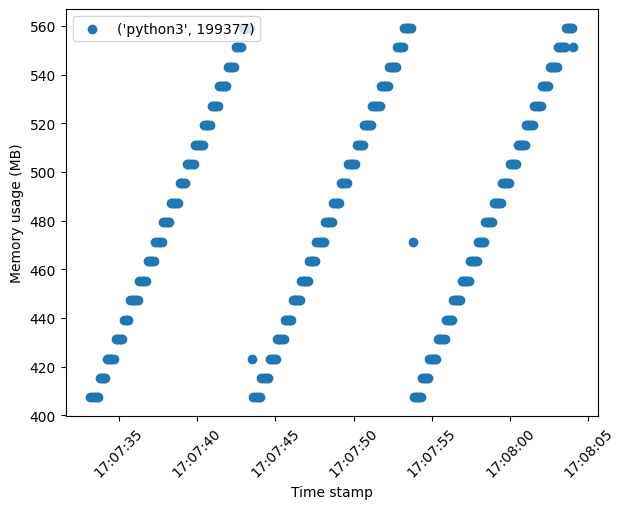

<module 'matplotlib.pyplot' from '/home/bpc/Documents/memorytools/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [14]:
mem_mon_sawtooth.plot_data_to_screen([proc.pid])

We see above the typically expected sawtooth shape of the sawtooth leak with expected peaks and resets in memory utilisation

## Run the leak detection algorithm

0.9999999994522613


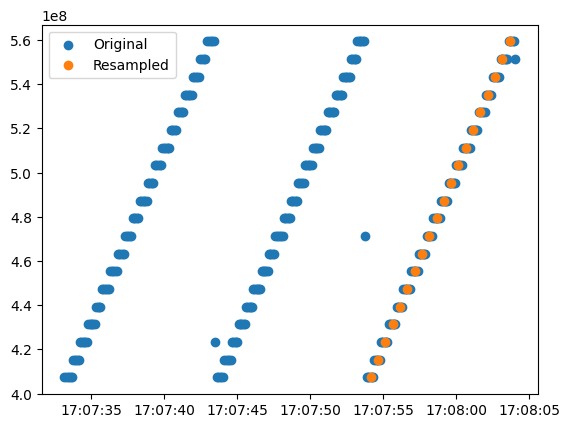

Abnormal memory usage detected in process: python3with pid 199377


In [15]:
assert proc.pid in mem_mon_sawtooth.detect_leaks("LBR")[1]

As seen above the test server's process pid is reported as anomalus with the testing. The graphic also gives information on the resampled window which suggests the error. We see that the test run is within an acceptable time for such a simple algorithm taking only 3m20s 

# Testing data with Gaps
The MemoryAnalysis class in the memorytools/memoryanalysis.py file includes a gap filtering process as a part of the preprocessing of data. This process is necessary because the MemoryMonitor does not necessarily run continuously, it starts and stops with the unit tests. Despite this, the data is still held in the same structure since in an ideal world the time between unit tests would be neglible although realistically it is not. The gap filtering process ensures that the analysis does not resample and create windows that include a large temporal gap in recorded memory information. Data with such gaps is not reliable when resampled and should be considered a separate dataset for the analysis purposes. The process works by finding gaps above a threshold in the data (MAX_TIME_DIFF) and splitting the data into separate datasets at these gaps. We then apply a resampling on the data between gaps

## Recording and simulating of data

In [1]:
mem_mon_gaps = MemoryMonitor(time_interval=0.05)
mem_mon_gaps.start_monitoring()
time.sleep(5)
simulate_sawtooth_memory_leak(proc)

# Create a gap in our memory recording
mem_mon_gaps.stop_monitoring()

time.sleep(10)

mem_mon_gaps.start_monitoring()
time.sleep(5)
#Back to memory monitoring!

simulate_memory_leak(proc,10)
time.sleep(5)
mem_mon_gaps.stop_monitoring()  

NameError: name 'MemoryMonitor' is not defined

## Visualising the simulator data 

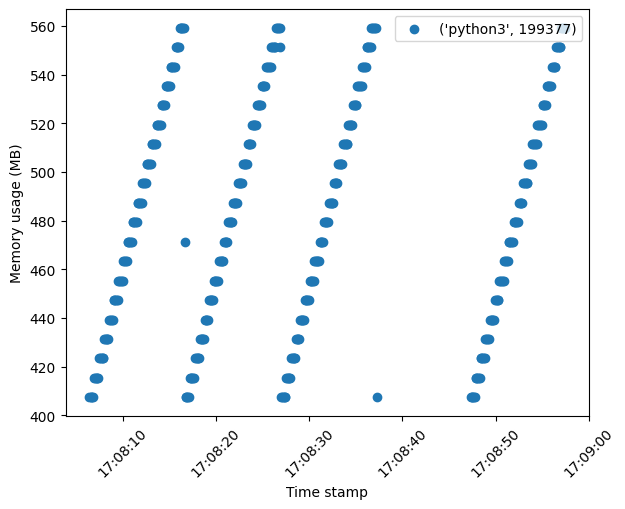

<module 'matplotlib.pyplot' from '/home/bpc/Documents/memorytools/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [17]:
mem_mon_gaps.plot_data_to_screen([proc.pid])

## Run the leak detection algorithm

0.9999625718103009


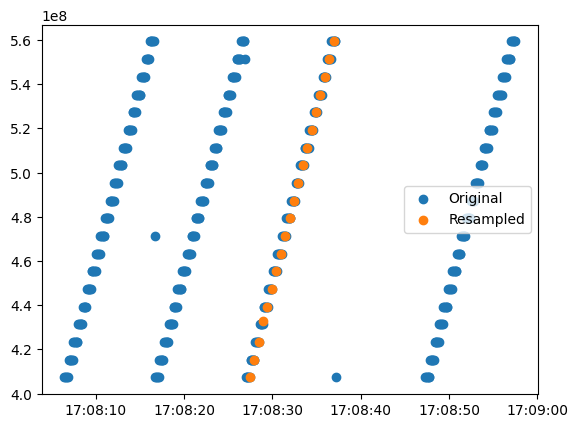

0.9994987376811064


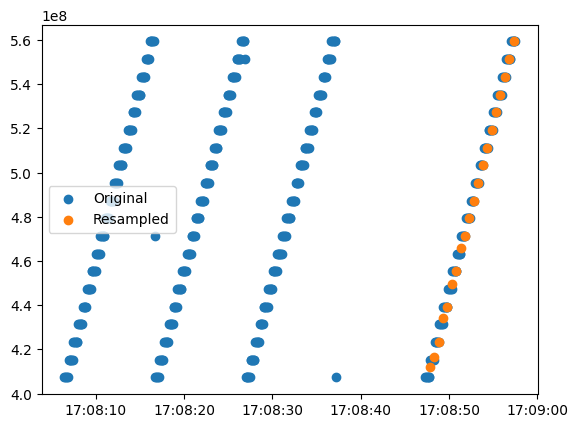

Abnormal memory usage detected in process: python3with pid 199377


(['python3'], [199377])

In [18]:
mem_mon_gaps.detect_leaks("LBR")

Again the leak detection algorithm has sucessfully detected an issue here, we see that there is not any detected leak in the relative data gap. We see that the time for the ananlysis of a system that is running for roughly 50s is 5 minuites. This again is a longer than ideal for a unit test but 'good enough' as a test to be run once before adding to trunk or as part of continuous integration. This is processing over 287 processes, an examplar number for the typical developers machine. 

In [19]:
len(mem_mon_gaps.processes)

281